In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import echopype as ep
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
fname = './data/GLIDER_SB_2018_v5-Phase0-D20180625-T104250-2.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')
ds

<xarray.Dataset>
Dimensions:                (ping_time: 96, frequency: 1, range_bin: 25296)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-25T10:42:50.967...
  * frequency              (frequency) float64 3.33e+05
  * range_bin              (range_bin) int32 0 1 2 3 ... 25292 25293 25294 25295
Data variables:
    Sv                     (frequency, ping_time, range_bin) float64 nan ... ...
    range                  (frequency, ping_time, range_bin) float64 0.0 ... ...
    temperature            (ping_time) float64 8.0 nan nan nan ... nan nan nan
    salinity               (ping_time) float64 35.0 nan nan nan ... nan nan nan
    pressure               (ping_time) float64 5.0 nan nan nan ... nan nan nan
    sound_speed            (ping_time) float64 1.482e+03 nan nan ... nan nan nan
    sound_absorption       (ping_time, frequency) float64 0.08015 nan ... nan
    sa_correction          object None
    gain_correction        object None
    equivalent_beam_angle  (frequency) float64 ...

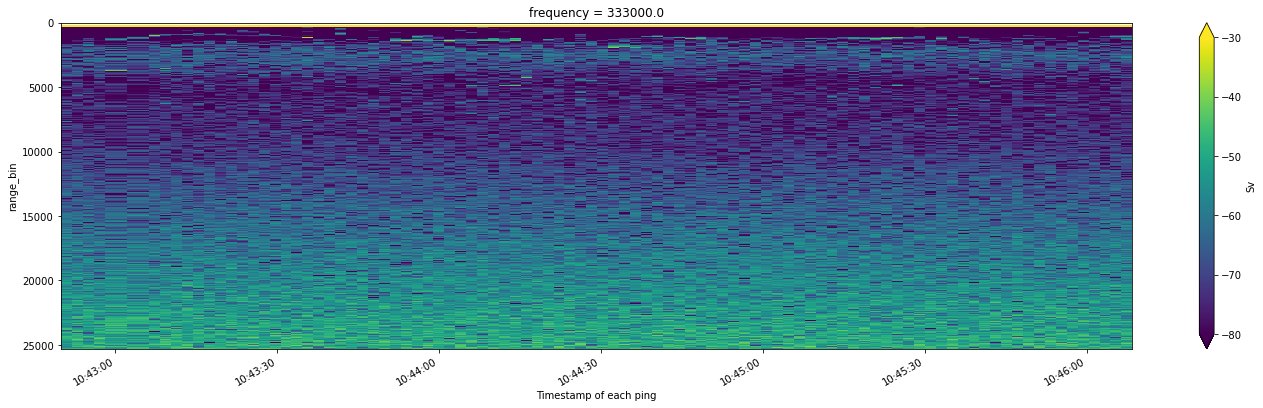

In [3]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# slice depth

In [4]:
ds = ds.isel(frequency=0,range_bin=slice(300,10000))
ds

<xarray.Dataset>
Dimensions:                (ping_time: 96, range_bin: 9700)
Coordinates:
  * ping_time              (ping_time) datetime64[ns] 2018-06-25T10:42:50.967...
    frequency              float64 3.33e+05
  * range_bin              (range_bin) int32 300 301 302 303 ... 9997 9998 9999
Data variables:
    Sv                     (ping_time, range_bin) float64 -15.82 ... -75.12
    range                  (ping_time, range_bin) float64 1.02 1.026 ... 58.53
    temperature            (ping_time) float64 8.0 nan nan nan ... nan nan nan
    salinity               (ping_time) float64 35.0 nan nan nan ... nan nan nan
    pressure               (ping_time) float64 5.0 nan nan nan ... nan nan nan
    sound_speed            (ping_time) float64 1.482e+03 nan nan ... nan nan nan
    sound_absorption       (ping_time) float64 0.08015 nan nan ... nan nan nan
    sa_correction          object None
    gain_correction        object None
    equivalent_beam_angle  float64 -21.0

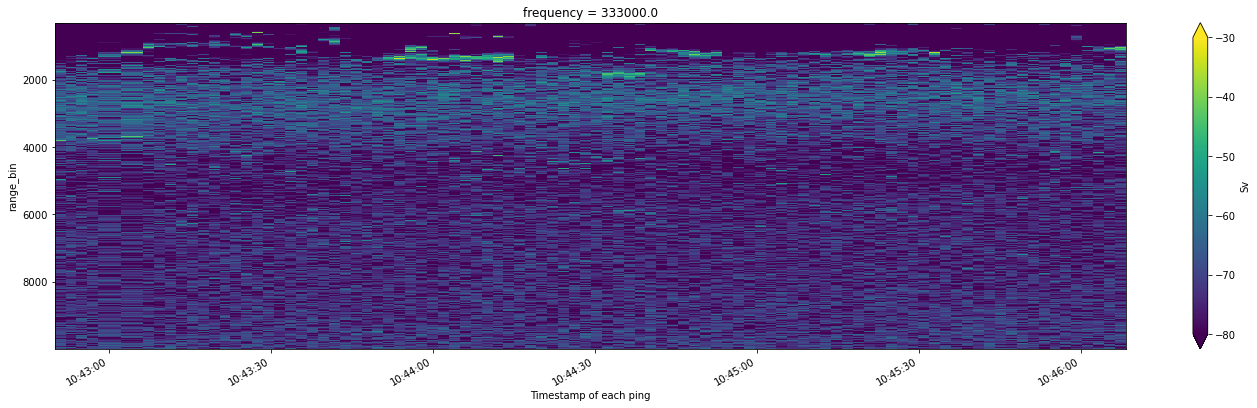

In [5]:
fig = ds.Sv.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# remove the bubbles

remove the bubbles by setting the surface values to min of the signal

In [6]:
ds_s = ds[['Sv']]

ds_s['Sv'][:,:100] = ds_s['Sv'].min()

window depth=48
window time=19
time min init: 2018-06-25T10:42:50.967000064, max: 2018-06-25T10:46:07.398000128
len time: 96
time min smooth: 2018-06-25T10:42:50.967000064, max: 2018-06-25T10:46:07.398000128
len time smooth: 96


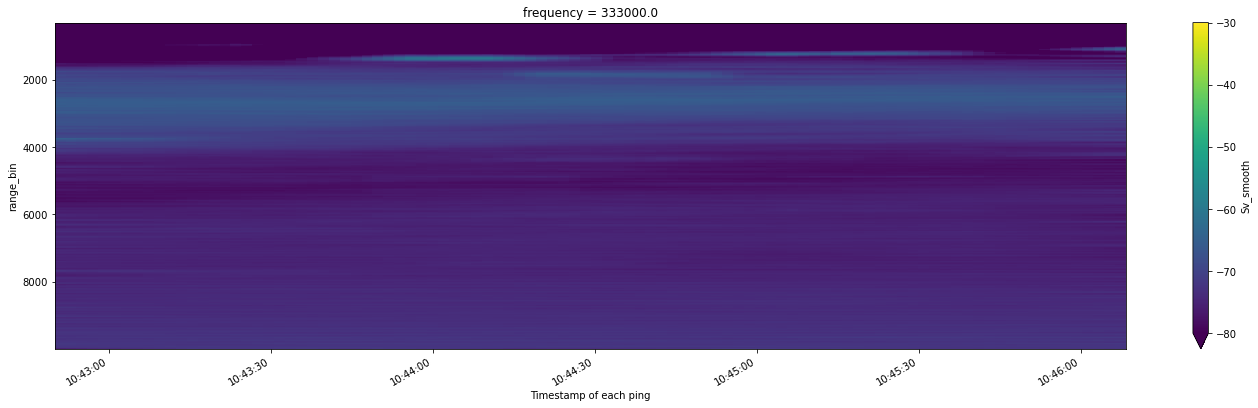

In [7]:
time_smoothing = max(len(ds_s['ping_time'].data)//5, 1)
depth_smoothing = len(ds_s['range_bin'].data)//200
print(f'window depth={depth_smoothing}')
print(f'window time={time_smoothing}')
print(f"time min init: {ds_s['ping_time'].min().data}, max: {ds_s['ping_time'].max().data}")
print(f"len time: {len(ds_s['ping_time'])}")

# smoothing on time axis
Sv_smooth = ds_s['Sv'].pad(ping_time=(time_smoothing, time_smoothing), mode='edge').rolling(ping_time=time_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(ping_time=np.arange(time_smoothing, len(ds_s['ping_time'])+time_smoothing))

# smoothing on depth axis
# Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='constant', constant_values=-120).rolling(range_bin=depth_smoothing,
#                                                                                                                                    center=True).mean()
Sv_smooth = Sv_smooth.pad(range_bin=(depth_smoothing, depth_smoothing), mode='edge').rolling(range_bin=depth_smoothing, center=True).mean()
Sv_smooth = Sv_smooth.isel(range_bin=np.arange(depth_smoothing, len(ds_s['range_bin'])+depth_smoothing))

print(f"time min smooth: {Sv_smooth['ping_time'].min().data}, max: {Sv_smooth['ping_time'].max().data}")
print(f"len time smooth: {len(Sv_smooth['ping_time'])}")

ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth.data)})
ds_s.Sv_smooth.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

In [8]:
stacked = ds_s.stack(z=('ping_time', 'range_bin'))
stacked

<xarray.Dataset>
Dimensions:    (z: 931200)
Coordinates:
    frequency  float64 3.33e+05
  * z          (z) MultiIndex
  - ping_time  (z) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2018-06-2...
  - range_bin  (z) int64 300 301 302 303 304 305 ... 9995 9996 9997 9998 9999
Data variables:
    Sv         (z) float64 -147.8 -147.8 -147.8 -147.8 ... -66.78 -72.64 -75.12
    Sv_smooth  (z) float64 -147.8 -147.8 -147.8 -147.8 ... -72.73 -72.78 -72.85

# Apply clustering
* KMeans: choose a number of cluster high enought to define the layer of interest as you want. Too low it might contain outside values. Do not hesitate to repeat the process

prep input vector:
2D with depth and Sv

Text(0.5, 1.0, 'Projection on depth/Sv axis, 1 ping_time')

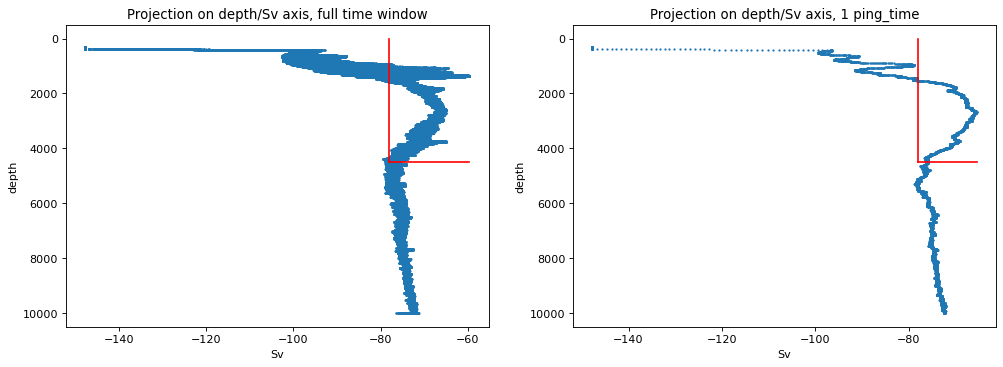

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), dpi=80)
sc = ax[0].scatter(stacked['Sv_smooth'].data, stacked['range_bin'].data, s=1)
ax[0].set_ylabel('depth')
ax[0].set_xlabel('Sv')
ax[0].plot([-78, stacked['Sv_smooth'].max()], [4500, 4500], color = 'r')
ax[0].plot([-78, -78], [0, 4500], color = 'r')
ax[0].invert_yaxis()
ax[0].set_title('Projection on depth/Sv axis, full time window')

instant = ds_s.isel(ping_time=10)
sc = ax[1].scatter(instant['Sv_smooth'].data, instant['range_bin'].data, s=1)
ax[1].set_ylabel('depth')
ax[1].set_xlabel('Sv')
ax[1].plot([-78, instant['Sv_smooth'].max()], [4500, 4500], color = 'r')
ax[1].plot([-78, -78], [0, 4500], color = 'r')
ax[1].invert_yaxis()
ax[1].set_title('Projection on depth/Sv axis, 1 ping_time')

In [10]:
N_CLUSTERS = 6

X = np.zeros([len(stacked['z']),2])
X[:,0] = stacked['Sv_smooth'].data
X[:,1] = stacked['range_bin'].data

X = StandardScaler().fit_transform(X)

print(f"shape X: {X.shape}")

shape X: (931200, 2)


In [11]:
%%time
kmeans = KMeans(n_clusters=N_CLUSTERS)
y_kmean = kmeans.fit_predict(X)
stacked = stacked.assign(variables={"clusters_kmean": (('z'), y_kmean)})
stacked

CPU times: user 35.4 s, sys: 16.9 s, total: 52.2 s
Wall time: 7.06 s


<xarray.Dataset>
Dimensions:         (z: 931200)
Coordinates:
    frequency       float64 3.33e+05
  * z               (z) MultiIndex
  - ping_time       (z) datetime64[ns] 2018-06-25T10:42:50.967000064 ... 2018...
  - range_bin       (z) int64 300 301 302 303 304 ... 9995 9996 9997 9998 9999
Data variables:
    Sv              (z) float64 -147.8 -147.8 -147.8 ... -66.78 -72.64 -75.12
    Sv_smooth       (z) float64 -147.8 -147.8 -147.8 ... -72.73 -72.78 -72.85
    clusters_kmean  (z) int32 5 5 5 5 5 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1 1 1 1

In [12]:
res = stacked.unstack('z')
res

<xarray.Dataset>
Dimensions:         (ping_time: 96, range_bin: 9700)
Coordinates:
    frequency       float64 3.33e+05
  * ping_time       (ping_time) datetime64[ns] 2018-06-25T10:42:50.967000064 ...
  * range_bin       (range_bin) int64 300 301 302 303 ... 9996 9997 9998 9999
Data variables:
    Sv              (ping_time, range_bin) float64 -147.8 -147.8 ... -75.12
    Sv_smooth       (ping_time, range_bin) float64 -147.8 -147.8 ... -72.85
    clusters_kmean  (ping_time, range_bin) int32 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1

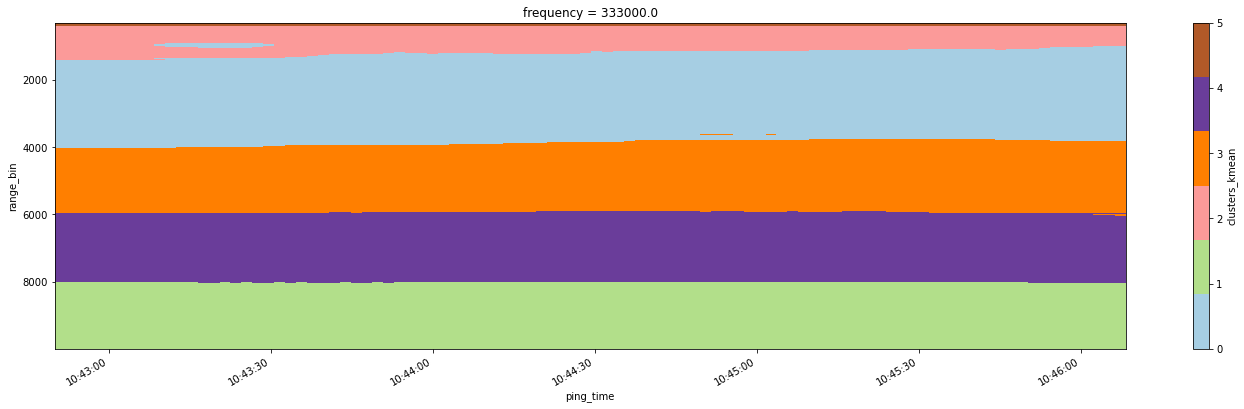

In [13]:
fig = res['clusters_kmean'].plot(x='ping_time', size=6, aspect=4, cmap=plt.cm.get_cmap('Paired', N_CLUSTERS)).figure
plt.gca().invert_yaxis()

In [256]:
# fig.savefig('kmean.png')

Text(0.5, 1.0, 'Projection on depth/Sv axis, 1 ping_time')

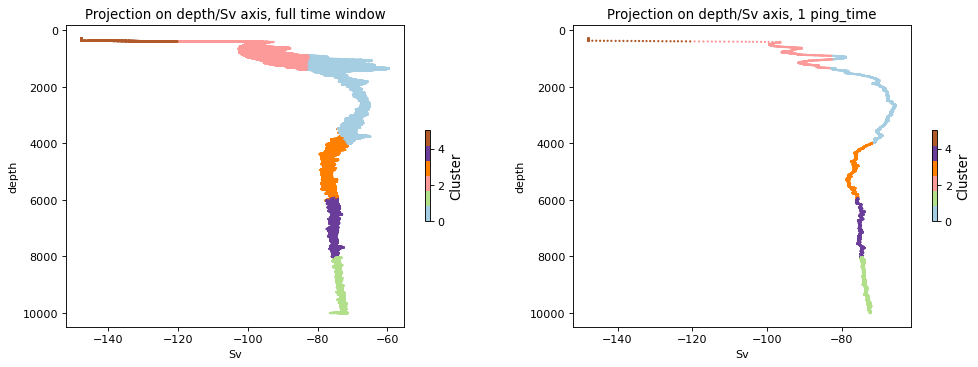

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), dpi=80)
sc = ax[0].scatter(stacked['Sv_smooth'].data, stacked['range_bin'].data, s=1, c=stacked['clusters_kmean'], cmap=plt.cm.get_cmap('Paired', N_CLUSTERS))
cbar = plt.colorbar(sc, ax=ax[0], shrink=0.3)
cbar.set_label('Cluster', fontsize=12)
ax[0].set_ylabel('depth')
ax[0].set_xlabel('Sv')
# ax[0].plot([-78, instant['Sv_smooth'].max()], [4500, 4500], color = 'r')
# ax[0].plot([-78, -78], [0, 4500], color = 'r')
ax[0].invert_yaxis()
ax[0].set_title('Projection on depth/Sv axis, full time window')

instant = res.isel(ping_time=10)
sc = ax[1].scatter(instant['Sv_smooth'].data, instant['range_bin'].data, s=1, c=instant['clusters_kmean'], cmap=plt.cm.get_cmap('Paired', N_CLUSTERS))
cbar = plt.colorbar(sc, ax=ax[1], shrink=0.3)
cbar.set_label('Cluster', fontsize=12)
ax[1].set_ylabel('depth')
ax[1].set_xlabel('Sv')
# ax[1].plot([-78, instant['Sv_smooth'].max()], [4500, 4500], color = 'r')
# ax[1].plot([-78, -78], [0, 4500], color = 'r')
ax[1].invert_yaxis()
ax[1].set_title('Projection on depth/Sv axis, 1 ping_time')

# Keep the custers you want
set cluster_id to the number of the cluster you want to extract: possible to keep multiple clusters

In [15]:
cluster_id = [0]

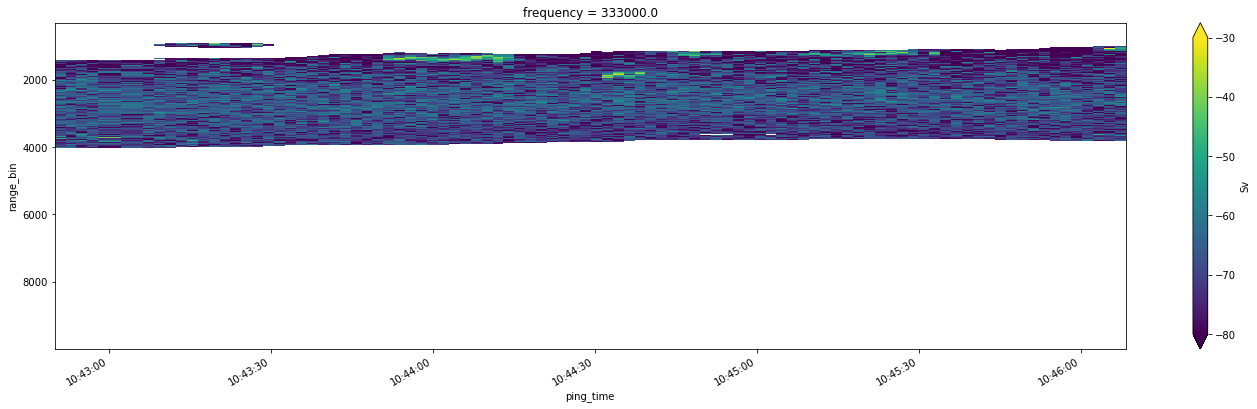

In [16]:
fig = res['Sv'].where(np.isin(res['clusters_kmean'].data, cluster_id)).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

In [180]:
# fig.figure.savefig('kmean_applied.png')

define cluster id again to compute the layer depth one by one

In [17]:
cluster_id=0

In [18]:
top_layer = res['range_bin'].where(res['clusters_kmean']==cluster_id).min(dim='range_bin')
bottom_layer = res['range_bin'].where(res['clusters_kmean']==cluster_id).max(dim='range_bin')

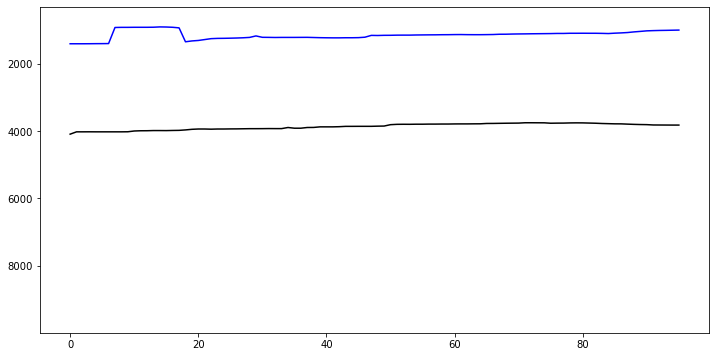

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(top_layer.data, color='blue', label='Sine wave')
ax.plot(bottom_layer.data, color='black', label='Cosine wave')

plt.ylim([300, 9999])
plt.gca().invert_yaxis()
fig.figure.savefig('kmean_depth_layer.png')

# add the layer info to dataset

In [20]:
ds = ds.assign(variables={"top_scattering_layer": (('ping_time'), top_layer.data)})
ds = ds.assign(variables={"bottom_scattering_layer": (('ping_time'), bottom_layer.data)})
ds

<xarray.Dataset>
Dimensions:                  (ping_time: 96, range_bin: 9700)
Coordinates:
  * ping_time                (ping_time) datetime64[ns] 2018-06-25T10:42:50.9...
    frequency                float64 3.33e+05
  * range_bin                (range_bin) int32 300 301 302 ... 9997 9998 9999
Data variables:
    Sv                       (ping_time, range_bin) float64 -147.8 ... -75.12
    range                    (ping_time, range_bin) float64 1.02 1.026 ... 58.53
    temperature              (ping_time) float64 8.0 nan nan nan ... nan nan nan
    salinity                 (ping_time) float64 35.0 nan nan ... nan nan nan
    pressure                 (ping_time) float64 5.0 nan nan nan ... nan nan nan
    sound_speed              (ping_time) float64 1.482e+03 nan nan ... nan nan
    sound_absorption         (ping_time) float64 0.08015 nan nan ... nan nan nan
    sa_correction            object None
    gain_correction          object None
    equivalent_beam_angle    float64 -21.0
    top_scattering_layer     (ping_time) float64 1.404e+03 1.404e+03 ... 997.0
    bottom_scattering_layer  (ping_time) float64 4.092e+03 ... 3.822e+03